# Tutorial: data integration for unpaired PBMC data (10x Genomics Visium)

In this tutorial, we demonstrate how to apply FGOT to integrate unpaired PBMC data (PBMC 3k RNA and PBMC 10k ATAC). The raw PBMC 3k RNA dataset is publicly assessible (https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz). The PBMC 10k ATAC dataset used was the same as that in PBMC paired tutorial. After preprocessing, the data used in this experiment can be downloaded from the website (https://drive.google.com/drive/folders/12cXm7N2nLvq5JE9qTfBcT6lkwA8ZJvxn). 

## load package

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [ ]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_unpaired_data/"
RNA_data = pd.read_csv(data_path+'pbmc3k_feature_selected_RNA_normalized_7clsters.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'pbmc10k_feature_250kb_ATAC_normalized_7clsters.txt', sep='\t', index_col=0)

In [ ]:
RNA_cluster = pd.read_csv(data_path+"new_pbmc3k_RNA_label_7clsters.txt", sep='\t')
ATAC_cluster = pd.read_csv(data_path+"new_pbmc10k_label_7clsters.txt", sep='\t',index_col=0)

In [65]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)
cell_names1= list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)

Dimensions of input datasets are:  X1 =  (2589, 7181)  X2 =  (2624, 191)
Dimensions of basic_labels are:  basic_labels1 =  (2589,)  basic_labels2 =  (2624,)


## build a priori feature graph

In [ ]:
promoters = pd.read_csv(data_path+'hg38.promoter.regions.txt', sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [7]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

72337it [00:00, 245601.74it/s]
41399it [00:00, 61877.64it/s]
100%|██████████| 191/191 [00:00<00:00, 291.74it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 191 7181 8251


100%|██████████| 8251/8251 [00:00<00:00, 1768199.59it/s]


,FCRL3,BCL9,TSHZ2,KLRB1,LINC00926,CD2,RTKN2,SLC2A1,PTGDR,AGL,...,ARID5B,ITGA6,SKAP1,PLD4,PBXIP1,GNG7,CCR7,CST7,BTBD8,CD53
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,1.0,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

In [ ]:
import anndata

In [ ]:
adata_tmp = anndata.read(data_path+"PBMC_scVI_adata.h5ad")
adata_tmp

/home/yangchenghui/anaconda3/envs/env_FGOT/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 5213 × 450
    obs: 'batch', 'cell_label', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_label_colors', 'neighbors'
    obsm: 'X_scVI', 'X_scVI_MDE'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
atac_emd = adata_tmp[adata_tmp.obs["batch"] == "RNA 10k"].obsm['X_scVI']
rna_emd = adata_tmp[adata_tmp.obs["batch"] == "RNA 3k"].obsm['X_scVI']
atac_emd.shape, rna_emd.shape

((2589, 30), (2624, 30))

In [11]:
S_m = pre.calculate_cell_similarity_byMNN(atac_emd, rna_emd, cell_names1, cell_names2, scale=0, knn =50)
r = pre.check_mnn_accuracy(S_m, basic_labels1, basic_labels2)
print("The accuracy of identifying MNN pairs is:", r)

the number of MNN pairs is  53331
The accuracy of identifying MNN pairs is: 0.8487258515087492


In [12]:
# import snn
s_tmp = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(s_tmp, 1)
snn1 = s_tmp[n2:,n2:] # ATAC
snn2 = s_tmp[:n2,:n2] # RNA

In [13]:
S_sm = pre.smooth_cell_similarity_byLaplacian2(S_m,snn1,snn2)
S = S_sm/np.max(S_sm) + S_m/np.max(S_m)

In [14]:
cost = np.array(np.exp(np.max(S) - S))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

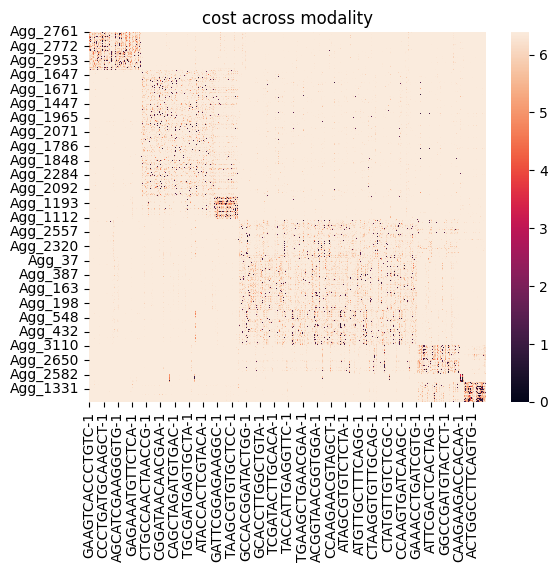

In [15]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [16]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [ ]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, device='cuda:9',eps_p = 1e-1, rho_mu=0, rho_nu=0)

minibatch = 1 and device =  cuda:9
the total number of computing batch is  25


100%|██████████| 25/25 [1:40:31<00:00, 241.27s/it]


## make multi-omics alignment from the transport tensor

In [51]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 8251/8251 [01:50<00:00, 74.83it/s]


(2589, 2624)

Text(0.5, 1.0, 'optimal transport matrix')

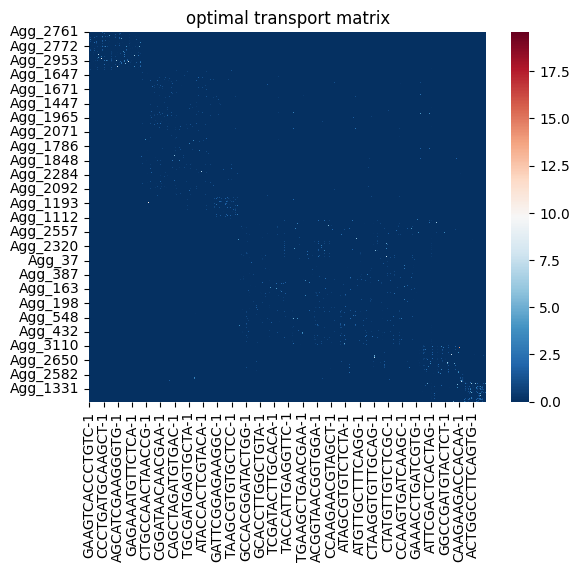

In [52]:
P_df = pd.DataFrame(P, index = cell_names1, columns = cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_P = P_df.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_P = sorted_P.iloc[:, sorted_rows]
sns.heatmap(sorted_P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [53]:
X1_aligned, X2_aligned = align(X1, X2, P)

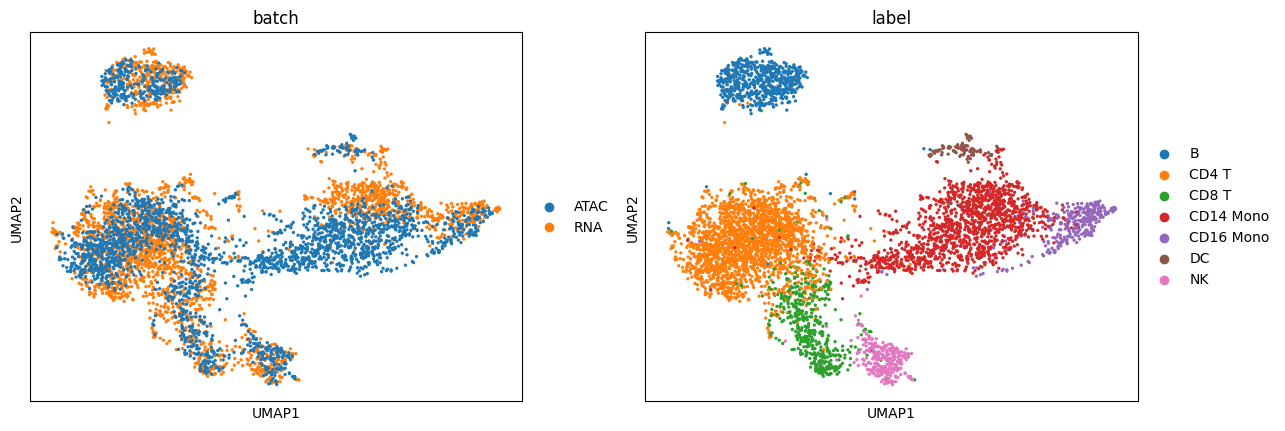

In [54]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'], show=False)
pl.savefig(data_path+"../FGOT_output/PBMC_FGOT_scVI_align.pdf")

In [55]:
adata_aligned.write_h5ad(data_path+"../FGOT_output/PBMC_FGOT_scVI_adata.h5ad")

## infer the cell type specific regulatory intensity from the transport tensor

In [56]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 191/191 [05:32<00:00,  1.74s/it]


,CD16 Mono,CD8 T,CD4 T,NK,CD14 Mono,DC,B
SKAP1-chr17-48456637-48457880,0.000003,0.000032,0.000009,0.000038,6.916711e-07,0.000018,0.000010
SKAP1-chr17-48546588-48549046,0.000010,0.000012,0.000009,0.000053,1.232642e-06,0.000029,0.000004
SKAP1-chr17-48294194-48295986,0.000007,0.000020,0.000005,0.000058,1.775690e-06,0.000023,0.000009
SKAP1-chr17-48444176-48445511,0.000002,0.000038,0.000009,0.000081,3.496832e-07,0.000006,0.000009
SKAP1-chr17-48526772-48527749,0.000007,0.000014,0.000007,0.000052,8.029887e-07,0.000017,0.000006
...,...,...,...,...,...,...,...
AGAP1-chr2-235390391-235390913,0.000000,0.000011,0.000000,0.000027,0.000000e+00,0.000000,0.000000
AGAP1-chr2-235614512-235614734,0.000000,0.000000,0.000000,0.000006,0.000000e+00,0.000000,0.000000
AGAP1-chr2-235493937-235494074,0.000000,0.000040,0.000000,0.000091,0.000000e+00,0.000000,0.000000
AGAP1-chr2-235666466-235666647,0.000000,0.000011,0.000000,0.000134,0.000000e+00,0.000000,0.000000


In [57]:
intensity_df.to_csv(data_path+'../FGOT_output/PBMC_FGOT_scVI_regulation.txt') 

## 验证调控的一致性

In [60]:
intensity_df_3k = pd.read_csv('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/PBMC_FGOT_scVI_regulation.txt',index_col = 0)
intensity_df_3k

,CD16 Mono,CD8 T,CD4 T,NK,CD14 Mono,DC,B
SKAP1-chr17-48456637-48457880,0.000003,0.000032,0.000009,0.000038,6.916711e-07,0.000018,0.000010
SKAP1-chr17-48546588-48549046,0.000010,0.000012,0.000009,0.000053,1.232642e-06,0.000029,0.000004
SKAP1-chr17-48294194-48295986,0.000007,0.000020,0.000005,0.000058,1.775690e-06,0.000023,0.000009
SKAP1-chr17-48444176-48445511,0.000002,0.000038,0.000009,0.000081,3.496832e-07,0.000006,0.000009
SKAP1-chr17-48526772-48527749,0.000007,0.000014,0.000007,0.000052,8.029887e-07,0.000017,0.000006
...,...,...,...,...,...,...,...
AGAP1-chr2-235390391-235390913,0.000000,0.000011,0.000000,0.000027,0.000000e+00,0.000000,0.000000
AGAP1-chr2-235614512-235614734,0.000000,0.000000,0.000000,0.000006,0.000000e+00,0.000000,0.000000
AGAP1-chr2-235493937-235494074,0.000000,0.000040,0.000000,0.000091,0.000000e+00,0.000000,0.000000
AGAP1-chr2-235666466-235666647,0.000000,0.000011,0.000000,0.000134,0.000000e+00,0.000000,0.000000


In [8]:
feature_matrix  = pd.read_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/pbmc_data/feature_association.csv",index_col=0)
feature_matrix

,NIPAL3,RCAN3AS,RCAN3,HYI,CD52,GAS5,LINC01135,COL24A1,RPL5,DIPK1A,...,PRKCH,PTGDR,GZMH,TNFAIP2,CEP128,TCF4,BCL2,LINC01478,SETBP1,TTC39C
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,1.0,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [ ]:
import pickle
# 从pickle文件读取数据
with open('/home/nas2/biod/yangchenghui/FGOT-master/output_P_tensor/P_tensor_PBMC_batchsize500_p1e-1_rho10.pickle', 'rb') as file:
    P_tensor = pickle.load(file)

In [12]:
label = pd.read_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/PBMC3kdata/new_pbmc10k_label.txt", sep="\t",index_col=0)
label

,cell,cluster
0,Agg_1,CD4 T
1,Agg_2,CD4 T
2,Agg_3,CD4 T
3,Agg_4,CD4 T
4,Agg_5,CD4 T
...,...,...
3192,Agg_3197,CD8 T
3193,Agg_3198,CD8 T
3194,Agg_3199,CD8 T
3195,Agg_3200,CD8 T


In [14]:
basic_labels1 = np.array(label.cluster)
basic_labels2 = basic_labels1
basic_labels1

array(['CD4 T', 'CD4 T', 'CD4 T', ..., 'CD8 T', 'CD8 T', 'CD8 T'],
      dtype=object)

In [15]:
intensity_df_10k = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df_10k

100%|██████████| 215/215 [16:34<00:00,  4.62s/it]


,CD16 Mono,MAIT,CD4 T,DC,CD8 T,B,CD8 Naive,CD14 Mono,pDC,Treg,NK,gdT
SKAP1-chr17-48456637-48457880,9.849931e-07,0.000109,3.098322e-06,4.613077e-07,0.000013,0.000004,5.386579e-06,5.937097e-08,0.000022,0.000154,1.180427e-05,0.000032
SKAP1-chr17-48546588-48549046,8.605329e-07,0.000019,2.841682e-06,1.863433e-06,0.000006,0.000001,6.224209e-06,2.143887e-07,0.000021,0.000081,1.376248e-05,0.000008
SKAP1-chr17-48294194-48295986,1.327038e-06,0.000190,2.333701e-06,4.900450e-07,0.000011,0.000003,2.156351e-06,2.021753e-07,0.000021,0.000015,1.658386e-05,0.000048
SKAP1-chr17-48444176-48445511,6.050827e-07,0.000044,2.618547e-06,1.113676e-10,0.000015,0.000003,1.055402e-05,1.377215e-08,0.000001,0.000008,1.551547e-05,0.000089
SKAP1-chr17-48526772-48527749,6.692401e-07,0.000018,2.342964e-06,4.354625e-08,0.000009,0.000003,5.884660e-06,1.251302e-07,0.000010,0.000080,1.398058e-05,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...
PATJ-chr1-61641679-61642101,1.507197e-05,0.000000,6.318150e-06,3.375850e-05,0.000012,0.000023,1.116636e-05,1.181581e-06,0.000140,0.000000,2.118271e-05,0.000000
NEGR1-chr1-72366388-72366903,7.611011e-05,0.000000,7.520823e-08,3.960497e-03,0.000000,0.000006,8.511223e-08,5.302105e-05,0.003596,0.000000,6.554297e-05,0.000000
NEGR1-chr1-72281087-72285474,1.322531e-04,0.000015,9.094862e-07,3.358946e-03,0.000003,0.000015,7.814730e-06,4.592480e-05,0.006731,0.000000,7.891579e-05,0.000000
NEGR1-chr1-72288865-72289444,6.314494e-05,0.000000,8.840880e-09,1.733869e-03,0.000003,0.000017,3.804740e-08,5.623165e-05,0.001228,0.000000,1.193114e-07,0.000000


In [18]:
intensity_df_10k.loc[intensity_df_3k.index, intensity_df_3k.columns].to_csv('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/PBMC_10k_FGOT_regulation.txt') 

In [62]:
intensity_df_10k = pd.read_csv('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/PBMC_10k_FGOT_regulation.txt',index_col = 0)
intensity_df_10k

,CD16 Mono,CD8 T,CD4 T,NK,CD14 Mono,DC,B
SKAP1-chr17-48456637-48457880,9.849931e-07,0.000013,3.098322e-06,0.000012,5.937097e-08,4.613077e-07,4.031860e-06
SKAP1-chr17-48546588-48549046,8.605329e-07,0.000006,2.841682e-06,0.000014,2.143887e-07,1.863433e-06,1.301023e-06
SKAP1-chr17-48294194-48295986,1.327038e-06,0.000011,2.333701e-06,0.000017,2.021753e-07,4.900450e-07,3.497831e-06
SKAP1-chr17-48444176-48445511,6.050827e-07,0.000015,2.618547e-06,0.000016,1.377215e-08,1.113676e-10,3.461187e-06
SKAP1-chr17-48526772-48527749,6.692401e-07,0.000009,2.342964e-06,0.000014,1.251302e-07,4.354625e-08,2.603716e-06
...,...,...,...,...,...,...,...
AGAP1-chr2-235390391-235390913,1.700667e-07,0.000151,1.434076e-05,0.000047,7.717076e-07,2.683076e-04,6.170613e-06
AGAP1-chr2-235614512-235614734,0.000000e+00,0.000000,1.678609e-06,0.000023,3.153190e-07,5.584226e-04,0.000000e+00
AGAP1-chr2-235493937-235494074,1.300403e-05,0.000097,6.445267e-07,0.000100,9.003088e-08,0.000000e+00,8.518016e-08
AGAP1-chr2-235666466-235666647,0.000000e+00,0.000066,3.911304e-06,0.000157,6.527039e-07,0.000000e+00,4.627060e-06


In [71]:
def celltype_regulatory_pred(intensity_df, celltype, peak_names, gene_names):
    peak_gene_pred1 = pd.DataFrame(0.0, index=peak_names, columns=gene_names)
    for idx, value in intensity_df[celltype].items():
        parts = idx.split("-", 1)
        gene = parts[0]
        peak = parts[1]
        if peak in peak_names and gene in gene_names:
            peak_gene_pred1.loc[peak, gene] = value
    return peak_gene_pred1

In [74]:
def verify_regulatory_sim(peak_gene_true,peak_gene_pred):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import roc_auc_score, average_precision_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import spearmanr
    from scipy.stats import kendalltau

    pred_mat = peak_gene_pred
    truth_mat = peak_gene_true

    results = []
    for gene in pred_mat.columns:
        y_score = pred_mat[gene].values
        if np.all(y_score == 0):
            continue
        y_true = truth_mat[gene].values
        if np.unique(y_true).size < 2:
            continue
        corr, p_value = spearmanr(y_score, y_true)
        tau, p_value = kendalltau(y_score, y_true)
        results.append({
            "gene": gene,
            "spearmanr": corr,
            "kendalltau": tau
        })

    metrics_df = pd.DataFrame(results)
    return metrics_df

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar(metrics_df):
    plt.figure(figsize=(5, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=metrics_df["spearmanr"])
    plt.ylim(0, 1)
    plt.title("Gene-wise spearmanr")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=metrics_df["kendalltau"])
    plt.ylim(0, 1)
    plt.title("Gene-wise kendalltau")

    plt.tight_layout()
    plt.show()

CD16 Mono

In [77]:
peak_gene_3k = celltype_regulatory_pred(intensity_df_3k,"CD16 Mono",peak_names,gene_names)
peak_gene_10k = celltype_regulatory_pred(intensity_df_10k,"CD16 Mono",peak_names,gene_names)

In [78]:
metrics_df1 = verify_regulatory_sim(peak_gene_10k,peak_gene_3k)
metrics_df1.to_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/pbmc3k10k_reg_sim_CD16Mono.csv", index=True)
metrics_df1

,gene,spearmanr,kendalltau
0,FCRL3,0.999996,0.998535
1,BCL9,0.999999,0.999369
2,TSHZ2,1.000000,0.999526
3,KLRB1,0.999994,0.998133
4,LINC00926,0.999999,0.999303
...,...,...,...
157,PBXIP1,0.999996,0.998624
158,GNG7,0.999994,0.998179
159,CCR7,0.999995,0.998312
160,CST7,0.999998,0.999121


CD8 T

In [82]:
peak_gene_3k = celltype_regulatory_pred(intensity_df_3k,"CD8 T",peak_names,gene_names)
peak_gene_10k = celltype_regulatory_pred(intensity_df_10k,"CD8 T",peak_names,gene_names)

In [83]:
metrics_df2 = verify_regulatory_sim(peak_gene_10k,peak_gene_3k)
metrics_df2.to_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/pbmc3k10k_reg_sim_CD8T.csv", index=True)
metrics_df2

,gene,spearmanr,kendalltau
0,FCRL3,0.999998,0.999138
1,BCL9,0.999999,0.999283
2,KLRB1,0.999997,0.998783
3,LINC00926,0.999999,0.999464
4,CD2,1.000000,0.999541
...,...,...,...
160,GNG7,0.999986,0.996988
161,CCR7,0.999993,0.998108
162,CST7,1.000000,0.999836
163,BTBD8,1.000000,0.999633


CD4 T

In [85]:
peak_gene_3k = celltype_regulatory_pred(intensity_df_3k,"CD4 T",peak_names,gene_names)
peak_gene_10k = celltype_regulatory_pred(intensity_df_10k,"CD4 T",peak_names,gene_names)

In [86]:
metrics_df3 = verify_regulatory_sim(peak_gene_10k,peak_gene_3k)
metrics_df3.to_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/pbmc3k10k_reg_sim_CD4T.csv", index=True)
metrics_df3

,gene,spearmanr,kendalltau
0,FCRL3,0.999994,0.998191
1,BCL9,1.000000,0.999632
2,TSHZ2,1.000000,0.999871
3,KLRB1,0.999999,0.999279
4,LINC00926,0.999999,0.999287
...,...,...,...
182,GNG7,0.999997,0.998757
183,CCR7,1.000000,0.999636
184,CST7,1.000000,0.999605
185,BTBD8,0.999999,0.999345


NK

In [88]:
peak_gene_3k = celltype_regulatory_pred(intensity_df_3k,"NK",peak_names,gene_names)
peak_gene_10k = celltype_regulatory_pred(intensity_df_10k,"NK",peak_names,gene_names)

In [89]:
metrics_df4 = verify_regulatory_sim(peak_gene_10k,peak_gene_3k)
metrics_df4.to_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/pbmc3k10k_reg_sim_NK.csv", index=True)
metrics_df4

,gene,spearmanr,kendalltau
0,FCRL3,1.000000,0.999628
1,KLRB1,0.999999,0.999484
2,CD2,0.999999,0.999124
3,SLC2A1,1.000000,0.999581
4,PTGDR,1.000000,0.999770
...,...,...,...
147,GNG7,0.999991,0.997688
148,CCR7,0.999995,0.998252
149,CST7,1.000000,0.999875
150,BTBD8,1.000000,0.999540


CD14 Mono

In [91]:
peak_gene_3k = celltype_regulatory_pred(intensity_df_3k,"CD14 Mono",peak_names,gene_names)
peak_gene_10k = celltype_regulatory_pred(intensity_df_10k,"CD14 Mono",peak_names,gene_names)

In [92]:
metrics_df5 = verify_regulatory_sim(peak_gene_10k,peak_gene_3k)
metrics_df5.to_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/pbmc3k10k_reg_sim_CD14Mono.csv", index=True)
metrics_df5

,gene,spearmanr,kendalltau
0,FCRL3,0.999994,0.998222
1,BCL9,1.000000,0.999620
2,TSHZ2,0.999999,0.999373
3,KLRB1,0.999997,0.998682
4,LINC00926,1.000000,0.999560
...,...,...,...
167,PBXIP1,0.999998,0.999107
168,GNG7,0.999997,0.998897
169,CCR7,0.999997,0.998845
170,CST7,0.999999,0.999317


DC

In [94]:
peak_gene_3k = celltype_regulatory_pred(intensity_df_3k,"DC",peak_names,gene_names)
peak_gene_10k = celltype_regulatory_pred(intensity_df_10k,"DC",peak_names,gene_names)

In [96]:
metrics_df6 = verify_regulatory_sim(peak_gene_10k,peak_gene_3k)
metrics_df6.to_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/pbmc3k10k_reg_sim_DC.csv", index=True)
metrics_df6

,gene,spearmanr,kendalltau
0,TSHZ2,1.000000,0.999682
1,CD2,0.999999,0.999280
2,PTGDR,0.981372,0.979782
3,AGL,1.000000,0.999648
4,SETBP1,0.999999,0.999512
...,...,...,...
131,PLD4,0.999998,0.999128
132,GNG7,0.999997,0.998793
133,CCR7,0.999996,0.998445
134,CST7,0.999999,0.999312


B

In [98]:
peak_gene_3k = celltype_regulatory_pred(intensity_df_3k,"B",peak_names,gene_names)
peak_gene_10k = celltype_regulatory_pred(intensity_df_10k,"B",peak_names,gene_names)

In [99]:
metrics_df7 = verify_regulatory_sim(peak_gene_10k,peak_gene_3k)
metrics_df7.to_csv("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC10kRNA&PBMC3kATAC/FGOT_output/pbmc3k10k_reg_sim_B.csv", index=True)
metrics_df7

,gene,spearmanr,kendalltau
0,FCRL3,1.000000,0.999679
1,BCL9,0.999999,0.999442
2,TSHZ2,1.000000,0.999605
3,LINC00926,1.000000,0.999883
4,CD2,0.999996,0.998607
...,...,...,...
159,PBXIP1,0.999997,0.998840
160,GNG7,0.999999,0.999453
161,CCR7,0.999999,0.999328
162,CST7,0.999999,0.999269
